## Prédiction de loyer améliorée

* __Objectif__ : améliorer le modèle de prédiction de loyer, à l'aide d'une feature (variable) supplémentaire en entrée, pour obtenir un modèle plus performant. L'arrondissement de l'appartement a été ajouté. 
* __Attendus__ :
    * séparation en training / testing set
    * 2 propositions d'amélioration du modèle qui obtiennent de meilleures performances que la "baseline" (la régression linéaire avec une seule feature)
    * sélection d'un modèle final à partir des performances
* __Rendu__ :
    * Fournir un fichier notebook avec l'ensemble des tests effectués ainsi que les outputs (images & graphes). 
    * Inclure des explications sur les points d'attentions dans les commentaires, ainsi que vos choix d'implémentation !

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Préparation des données

In [16]:
house_data = pd.read_csv('house_data.csv')

In [17]:
# dimensions du tableau
house_data.shape

(827, 3)

In [18]:
# aperçu de la fin du tableau
house_data.tail()

,price,surface,arrondissement
822,850,35.00,10.0
823,700,10.00,10.0
824,1280,34.00,10.0
825,1545,65.00,10.0
826,1000,21.43,10.0


In [19]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 3 columns):
price             827 non-null int64
surface           822 non-null float64
arrondissement    822 non-null float64
dtypes: float64(2), int64(1)
memory usage: 19.5 KB


In [20]:
house_data.arrondissement.unique()

array([ 1., nan,  2.,  3.,  4., 10.])

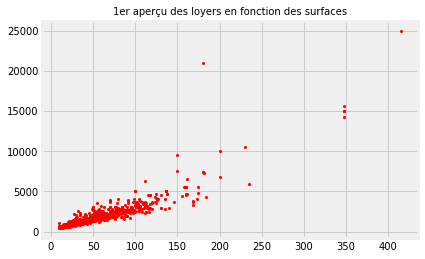

In [21]:
#plt.style.use('fivethirtyeight')
plt.title("1er aperçu des loyers en fonction des surfaces", fontsize='medium')
plt.plot(house_data['surface'], house_data['price'], 'ro', markersize=2)

In [22]:
# on enlève les valeurs lignes avec un prix sans surface ou arrondissement
house_data = house_data.dropna(axis=0)

# on enlève les valeurs aberrantes
house_data = house_data[(house_data['price'] < 20000) & (house_data['surface'] < 300)]

In [23]:
house_data.isna().any()

price             False
surface           False
arrondissement    False
dtype: bool

## Visualisation des données

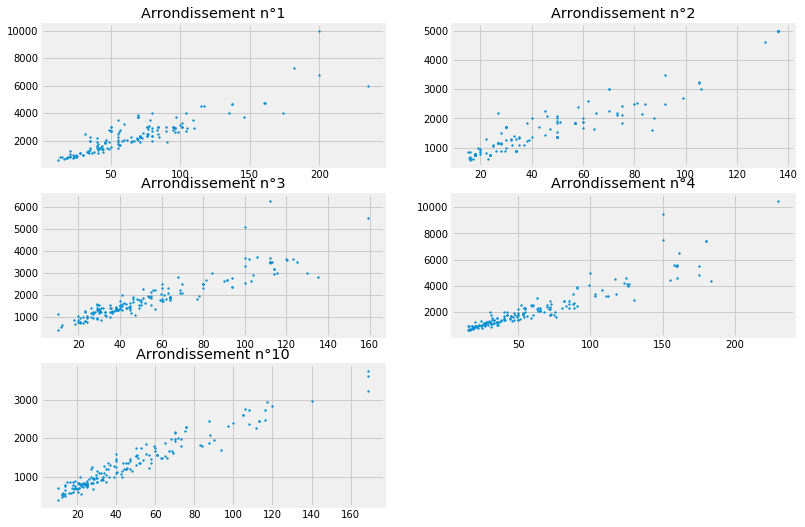

In [40]:
# visualisation par arrondissmeent 
fig = plt.figure(figsize=(12,12))
i = 0
for arr in house_data['arrondissement'].unique():
    i += 1
    mydata = house_data[house_data.arrondissement == arr]
    fig.add_subplot(4,2,i).set_title('Arrondissement n°{}'.format(int(arr)))
    plt.scatter(mydata.surface, mydata.price, s=3)

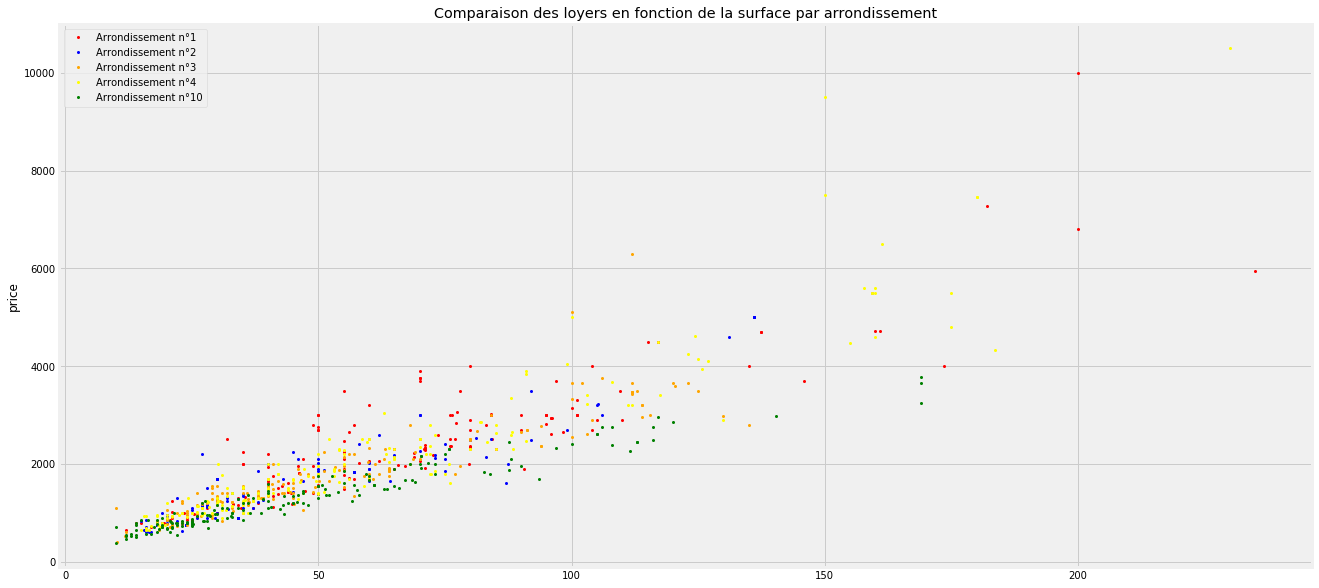

In [49]:
plt.figure(figsize=(20,10))
plt.title("Comparaison des loyers en fonction de la surface par arrondissement")
plt.ylabel('price')
i, colors = 0, ['red', 'blue', 'orange', 'yellow', 'green']

for arr in house_data['arrondissement'].unique():
    mydata = house_data[house_data.arrondissement == arr]
    plt.plot(mydata.surface, mydata.price, '.', markersize=4, color=colors[i], label='Arrondissement n°{}'.format(int(arr)))
    i += 1
    
plt.legend(loc='upper left');

## Analyse d'ensemble des données

In [52]:
house_data.describe()

,price,surface,arrondissement
count,815.000000,815.000000,815.000000
mean,1879.229448,55.685583,4.165644
std,1215.919826,36.517695,3.204465
min,390.000000,10.000000,1.000000
25%,1050.000000,28.345000,2.000000
50%,1550.000000,46.000000,3.000000
75%,2317.500000,72.000000,4.000000
max,10500.000000,235.000000,10.000000


##### Les 3 quarts des prix sont relativement bas (inférieurs à 2 320€). Ici arrondissement est un variable catégorique et non quantitative:
    
    https://medium.com/crim/manipuler-les-variables-cat%C3%A9goriques-dans-un-jeu-de-donn%C3%A9es-6973c54c9827

## Séparation en training / testing set

Les algorithmes d’apprentissage automatique prennent des valeurs numériques en entrée. Il faut trouver une façon de transformer nos modalités en données numériques.

De plus, la façon dont cette transformation est opérée est très importante. En effet, le codage des variables catégoriques nuit généralement à la performance des algorithmes d’apprentissage. Un codage peut s’avérer plus judicieux qu’un autre. 

Le one hot encoding est la méthode la plus populaire pour transformer une variable catégorique en variable numérique. Sa popularité réside principalement dans la facilité d’application. De plus, pour beaucoup de problèmes, elle donne de bons résultats. 



In [55]:
house_data_prepared = pd.get_dummies(house_data, prefix_sep="_", columns=["arrondissement"])
house_data_prepared.head()

,price,surface,arrondissement_1.0,arrondissement_2.0,arrondissement_3.0,arrondissement_4.0,arrondissement_10.0
0,1820,46.1,1,0,0,0,0
1,1750,41.0,1,0,0,0,0
2,1900,55.0,1,0,0,0,0
3,1950,46.0,1,0,0,0,0
4,1950,49.0,1,0,0,0,0


In [56]:
# Ici les données ou features sont les surfaces et les arrondissements
# et les cibles les loyers
X = house_data_prepared.iloc[:,1:7]
y = house_data_prepared['price']

# training set pour entraîner les modèles dans un 1er temps / puis testing set plus tard pour vérification
# répartition classique 80/20 entre training et testing set.
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [58]:
xtrain.tail()

,surface,arrondissement_1.0,arrondissement_2.0,arrondissement_3.0,arrondissement_4.0,arrondissement_10.0
353,36.00,0,0,1,0,0
727,35.00,0,0,0,0,1
826,21.43,0,0,0,0,1
372,94.00,0,0,1,0,0
723,38.67,0,0,0,0,1


In [59]:
ytest.head()

573    1750
620     885
786    2748
352    1100
114    3000
Name: price, dtype: int64

En suivant le diagramme pour choisir le bon modèle d'estimation ici : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

Regression -> samples < 100k -> few features should be important -> on obtient 2 types de modèles qui pourraient convenir : Lasso & ElasticNet
Néanmoins il semblearait que toutes les méthodes suivantes fonctionnent (avec + ou - d'efficacité) :
* LinearRegression(),
* RandomForestRegressor(),
* KNeighborsRegressor(),
* SVR()

#### Procédure:

source : https://makina-corpus.com/blog/metier/2017/initiation-au-machine-learning-avec-python-pratique

L'algorithme de prédiction est représenté par une classe.
* Commencer par choisir l'algorithme à utiliser appelé prédicteur/classifieur/estimator. Les algorithmes sont des classes Python. Les données sont toujours des tableaux Numpy/Scipy/Pandas/Python
* Préciser ses éventuels paramètres, appelés hyperparamètres en instanciant la classe
* Alimenter avec la fonction __fit__ dans le cas d'un apprentissage supervisé
* Lancer la prédiction sur un ensemble de valeurs via la fonction __predict__ parfois appelée transform dans le cas de l'apprentissage non supervisé
* Vérifier la pertinence du modèle

## Utilisation de plusieurs modèles et comparaison des résultats

In [62]:
model_list = [LinearRegression(),
            RandomForestRegressor(n_estimators=100, max_features='sqrt'),
            KNeighborsRegressor(n_neighbors=6),
            SVR(kernel='linear')]
 
model_results = pd.DataFrame()
tmp = {}
 
for model in model_list:
    # on récupère le nom du modele
    m = str(model)
    
    # et on le stocke
    tmp['Model'] = m[:m.index('(')]
    
    # on fit le modele sur training dataset
    model.fit(xtrain, ytrain)
   
    # on predit les prix sur le test dataset et on calcul r^2
    tmp['r2'] = r2_score(ytest, model.predict(xtest))
    model_results = model_results.append([tmp])

model_results.set_index('Model', inplace=True)

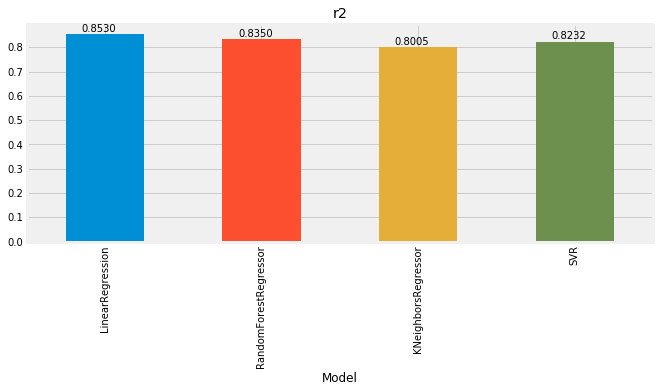

In [65]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 4))

for i, v in enumerate(model_results.r2):
    axes.text(i-0.15, v + .01, "%.4f" % v)
    
model_results.r2.plot(ax=axes, kind='bar', title='r2')
plt.show()

##### Pour ce cas précis la régression linéaire est le modèle le plus efficace avec un score de r² de 0,8677 (plus c'est proche de 1 meilleur c'est)

In [70]:
reg_lin = LinearRegression()
reg_lin.fit(xtrain,ytrain)

error = 1 - reg_lin.score(xtest, ytest)
print('Erreur regression linéaire: %f' % error)

Erreur regression linéaire: 0.146966


In [71]:
# les coefficients
print(reg_lin.coef_)

[  29.4025909   132.19236238   20.83565396   -9.46423543  172.56942704
 -316.13320794]
